In [7]:
import pandas as pd 
import glob
import librosa
import numpy as np
#import tensorflow as tf 
file_paths = glob.glob("E:/Users/atag3/Documents/Gunshot_Data/*.wav")
labels = [os.path.basename(x) for x in glob.glob('E:/Users/atag3/Documents/Gunshot_Data/*.wav')]

dat = {'file_path':file_paths,'label':labels}
gun_dat = pd.DataFrame(dat)


In [8]:
# Copyright 2017 The TensorFlow Authors All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Global parameters for the VGGish model.
See vggish_slim.py for more information.
"""

# Architectural constants.
NUM_FRAMES = 496  # Frames in input mel-spectrogram patch.
NUM_BANDS = 64  # Frequency bands in input mel-spectrogram patch.
EMBEDDING_SIZE = 128  # Size of embedding layer.

# Hyperparameters used in feature and example generation.
SAMPLE_RATE = 16000
STFT_WINDOW_LENGTH_SECONDS = 0.04
STFT_HOP_LENGTH_SECONDS = 0.009
NUM_MEL_BINS = NUM_BANDS
MEL_MIN_HZ = 1250
MEL_MAX_HZ = 7500
LOG_OFFSET = 0.01  # Offset used for stabilized log of input mel-spectrogram.
EXAMPLE_WINDOW_SECONDS = 4.96  # Each example contains 96 10ms frames
EXAMPLE_HOP_SECONDS = 4.96     # with zero overlap.

# Parameters used for embedding postprocessing.
PCA_EIGEN_VECTORS_NAME = 'pca_eigen_vectors'
PCA_MEANS_NAME = 'pca_means'
QUANTIZE_MIN_VAL = -2.0
QUANTIZE_MAX_VAL = +2.0

# Hyperparameters used in training.
INIT_STDDEV = 0.01  # Standard deviation used to initialize weights.
LEARNING_RATE = 1e-4  # Learning rate for the Adam optimizer.
ADAM_EPSILON = 1e-8  # Epsilon for the Adam optimizer.

# Names of ops, tensors, and features.
INPUT_OP_NAME = 'vggish/input_features'
INPUT_TENSOR_NAME = INPUT_OP_NAME + ':0'
OUTPUT_OP_NAME = 'vggish/embedding'
OUTPUT_TENSOR_NAME = OUTPUT_OP_NAME + ':0'
AUDIO_EMBEDDING_FEATURE_NAME = 'audio_embedding'

In [9]:
import numpy as np
import resampy
import mel_features

def preprocess_sound(data, sample_rate):
  """Converts audio waveform into an array of examples for VGGish.
  Args:
    data: np.array of either one dimension (mono) or two dimensions
      (multi-channel, with the outer dimension representing channels).
      Each sample is generally expected to lie in the range [-1.0, +1.0],
      although this is not required.
    sample_rate: Sample rate of data.
  Returns:
    3-D np.array of shape [num_examples, num_frames, num_bands] which represents
    a sequence of examples, each of which contains a patch of log mel
    spectrogram, covering num_frames frames of audio and num_bands mel frequency
    bands, where the frame length is vggish_params.STFT_HOP_LENGTH_SECONDS.
  """
  # Convert to mono.

  if len(data.shape) > 1:
    data = np.mean(data, axis=1)
  # Resample to the rate assumed by VGGish.
  if sample_rate != SAMPLE_RATE:
    data = resampy.resample(data, sample_rate, SAMPLE_RATE)

  # Compute log mel spectrogram features.
  log_mel = mel_features.log_mel_spectrogram(
      data,
      audio_sample_rate=SAMPLE_RATE,
      log_offset=LOG_OFFSET,
      window_length_secs=STFT_WINDOW_LENGTH_SECONDS,
      hop_length_secs=STFT_HOP_LENGTH_SECONDS,
      num_mel_bins=NUM_MEL_BINS,
      lower_edge_hertz=MEL_MIN_HZ,
      upper_edge_hertz=MEL_MAX_HZ)

  # Frame features into examples.
  features_sample_rate = 1.0 / STFT_HOP_LENGTH_SECONDS
  example_window_length = int(round(
      EXAMPLE_WINDOW_SECONDS * features_sample_rate))
  example_hop_length = int(round(
      EXAMPLE_HOP_SECONDS * features_sample_rate))
  log_mel_examples = mel_features.frame(
      log_mel,
      window_length=10,
      hop_length=512)

  log_mel_examples = np.resize(log_mel_examples,(1,NUM_FRAMES, NUM_BANDS,1))
  return log_mel_examples

In [10]:
import sys
sys.path.append('/home/hudi/anaconda2/lib/python2.7/site-packages/h5py')
sys.path.append('/home/hudi/anaconda2/lib/python2.7/site-packages/Keras-2.0.6-py2.7.egg')


from keras.models import Model
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.engine.topology import get_source_inputs
from tensorflow.keras import backend as k
#K.clear_session()



def VGGish(load_weights=True, weights='audioset',
           input_tensor=None, input_shape=None,
           out_dim=None, include_top=True, pooling='avg'):
    '''
    An implementation of the VGGish architecture.
    :param load_weights: if load weights
    :param weights: loads weights pre-trained on a preliminary version of YouTube-8M.
    :param input_tensor: input_layer
    :param input_shape: input data shape
    :param out_dim: output dimension
    :param include_top:whether to include the 3 fully-connected layers at the top of the network.
    :param pooling: pooling type over the non-top network, 'avg' or 'max'
    :return: A Keras model instance.
    '''

    if weights not in {'audioset', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `audioset` '
                         '(pre-training on audioset).')

    if out_dim is None:
        out_dim = EMBEDDING_SIZE

    # input shape
    if input_shape is None:
        input_shape = (NUM_FRAMES, NUM_BANDS, 1)

    if input_tensor is None:
        aud_input = Input(shape=input_shape, name='input_1')
    else:
        if not K.is_keras_tensor(input_tensor):
            aud_input = Input(tensor=input_tensor, shape=input_shape, name='input_1')
        else:
            aud_input = input_tensor



    # Block 1
    x = Conv2D(64, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv1')(aud_input)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool1')(x)

    # Block 2
    x = Conv2D(128, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool2')(x)

    # Block 3
    x = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv3/conv3_1')(x)
    x = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv3/conv3_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool3')(x)

    # Block 4
    x = Conv2D(512, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv4/conv4_1')(x)
    x = Conv2D(512, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv4/conv4_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool4')(x)



    if include_top:
        # FC block
        x = Flatten(name='flatten_')(x)
        x = Dense(4096, activation='relu', name='vggish_fc1/fc1_1')(x)
        x = Dense(4096, activation='relu', name='vggish_fc1/fc1_2')(x)
        x = Dense(out_dim, activation='relu', name='vggish_fc2')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)


    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = aud_input
    # Create model.
    model = Model(inputs, x, name='VGGish')


    # load weights
    if load_weights:
        if weights == 'audioset':
            if include_top:
                model.load_weights('vggish_audioset_weights.h5')
            else:
                model.load_weights('vggish_audioset_weights_without_fc2.h5')
        else:
            print("failed to load weights")

    return model

In [7]:

model=VGGish(weights='audioset', include_top=False)
#model.summary()

In [11]:
y, sr = librosa.core.load(file_paths[0], sr=16000)
log_mel = mel_features.log_mel_spectrogram(
      y,
      audio_sample_rate=16000,
      log_offset=LOG_OFFSET,
      window_length_secs=STFT_WINDOW_LENGTH_SECONDS,
      hop_length_secs=STFT_HOP_LENGTH_SECONDS,
      num_mel_bins=NUM_MEL_BINS,
      lower_edge_hertz=MEL_MIN_HZ,
      upper_edge_hertz=MEL_MAX_HZ)
log_mel
 # Frame features into examples.
features_sample_rate = 1.0 / STFT_HOP_LENGTH_SECONDS
example_window_length = int(round(
    EXAMPLE_WINDOW_SECONDS * features_sample_rate))
example_hop_length = int(round(
    EXAMPLE_HOP_SECONDS * features_sample_rate))
log_mel_examples = mel_features.frame(
      log_mel,
      window_length=20 ,
      hop_length=512 )
dat=log_mel_examples

In [321]:
dat


0.01

In [12]:
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name,sr=16000)
        mels = preprocess_sound(audio, sample_rate)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mels

# Load various imports 
import pandas as pd
import os
import librosa

# Set the path to the full UrbanSound dataset 
features = []

# Iterate through each sound file and extract the features 
for i in range(len(file_paths)):
    
    class_label = labels[i].split("_")[0]
    data = extract_features(file_paths[i])
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files')

Finished feature extraction from  1108  files


In [55]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
y = np.array(featuresdf.class_label.tolist())
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

#try and add our labels to theirs?
#result = np.zeros([yy.shape[0],515])
#result[:yy.shape[0],:yy.shape[1]] = yy

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [383]:
result = np.zeros([yy.shape[0],514])
#result[:yy.shape[0],:yy.shape[1]] = a

array([[[[-1.10808681],
         [-0.80703893],
         [-0.91489608],
         ...,
         [ 0.268103  ],
         [ 0.2950644 ],
         [ 0.2564927 ]],

        [[-0.84208031],
         [-0.22582216],
         [-0.54803208],
         ...,
         [ 0.22654741],
         [-0.04218933],
         [ 0.0869166 ]],

        [[-0.35628106],
         [-0.2214525 ],
         [-0.52991703],
         ...,
         [ 0.02881391],
         [ 0.27438186],
         [ 0.29930451]],

        ...,

        [[-0.75618366],
         [-1.17296514],
         [-0.85442694],
         ...,
         [ 0.06309868],
         [ 0.56560143],
         [ 0.25824358]],

        [[-0.83316679],
         [-0.83891562],
         [-0.37135319],
         ...,
         [ 0.36313438],
         [ 0.65863783],
         [ 0.15123552]],

        [[-0.92956549],
         [-0.80810404],
         [-0.49281186],
         ...,
         [ 0.66830787],
         [ 0.5538734 ],
         [ 0.56828878]]]])

In [61]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Conv1D, Convolution1D, MaxPooling1D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 
import tensorflow as tf
from keras.callbacks import EarlyStopping
import keras

#try max pooling layer since we care more about extreme values.
new_inputs = keras.Input(shape=(496,64,1))
model = VGGish(weights='audioset', include_top=False, input_shape=(496,64,1), pooling='avg')
#model.trainable = False

flat1 = Flatten()(model.layers[-1].output)
class3 = Dense(84, activation='relu')(flat1)


#drop = Dropout(.2)(class1)
class2 = Dense(64, activation='relu')(class3)
#drop2 = Dropout(.2)(class2)

#new_dense = Dense(units = 32, activation = 'relu')(drop2)

last_dense = Dense(units = 10, activation = 'relu')(class2)

#model.add(GlobalAveragePooling2D())

output = Dense(3, activation='softmax')(last_dense)


model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()
#model = keras.models.Model(inputs=model.input, outputs=outputs, name="final_mod")
#outputs = keras.layers.Dense(3, activation='softmax')(model)


Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 496, 64, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 496, 64, 64)       640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 248, 32, 64)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 248, 32, 128)      73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 124, 16, 128)      0         
_________________________________________________________________
conv3/conv3_1 (Conv2D)       (None, 124, 16, 256)      295168    
_________________________________________________________________
conv3/conv3_2 (Conv2D)       (None, 124, 16, 256)    

In [57]:
x_train = x_train.reshape(x_train.shape[0],496,64,1)
x_test = x_test.reshape(x_test.shape[0],496,64,1)

# Compile the model
model.compile(loss='kullback_leibler_divergence', metrics=['accuracy'], optimizer='adam')

# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy) 

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 496, 64, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 496, 64, 64)       640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 248, 32, 64)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 248, 32, 128)      73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 124, 16, 128)      0         
_________________________________________________________________
conv3/conv3_1 (Conv2D)       (None, 124, 16, 256)      295168    
_________________________________________________________________
conv3/conv3_2 (Conv2D)       (None, 124, 16, 256)    

In [64]:
def train(model,X_train, X_test, y_train, y_test):    

    # compile the model 
    from keras.optimizers import SGD
    opt = SGD(lr=0.00001)
    model.compile(loss = "categorical_crossentropy", metrics=['accuracy'],optimizer = opt)       
    #model.compile(loss = 'categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

    print(model.summary())

    print("training for 100 epochs with batch size 20")
    
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=20, restore_best_weights=True )

    model.fit(X_train,y_train,batch_size= 10, epochs = 300, validation_data=(X_test,y_test),callbacks=[es])

    # save model to disk
    print("Saving model to disk")

In [65]:
with tf.device("gpu:0"):
    train(model,x_train,x_test,y_train,y_test)

==============] - 121s 1s/step - loss: 1.0762 - accuracy: 0.5632 - val_loss: 1.0759 - val_accuracy: 0.5721
Epoch 163/300
89/89 [==============================] - 122s 1s/step - loss: 1.0761 - accuracy: 0.5632 - val_loss: 1.0758 - val_accuracy: 0.5721
Epoch 164/300
89/89 [==============================] - 124s 1s/step - loss: 1.0760 - accuracy: 0.5632 - val_loss: 1.0756 - val_accuracy: 0.5721
Epoch 165/300
89/89 [==============================] - 123s 1s/step - loss: 1.0758 - accuracy: 0.5632 - val_loss: 1.0755 - val_accuracy: 0.5721
Epoch 166/300
89/89 [==============================] - 121s 1s/step - loss: 1.0757 - accuracy: 0.5632 - val_loss: 1.0754 - val_accuracy: 0.5721
Epoch 167/300
89/89 [==============================] - 121s 1s/step - loss: 1.0756 - accuracy: 0.5632 - val_loss: 1.0753 - val_accuracy: 0.5721
Epoch 168/300
89/89 [==============================] - 121s 1s/step - loss: 1.0755 - accuracy: 0.5632 - val_loss: 1.0752 - val_accuracy: 0.5721
Epoch 169/300
89/89 [========

In [66]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Print confusion matrix for Gaussian
y_pred = (model.predict(x_train)>.5)
GNB_confusion = confusion_matrix(y_train.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(dpi=150)
sns.heatmap(GNB_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('glock')
plt.ylabel('p320')
plt.title('NN confusion matrix  [0=glock 1=P320]');

# Print confusion matrix for Gaussian

y_pred_t = (model.predict(x_test)>.5)
rf_confusion = confusion_matrix(y_test.argmax(axis=1), y_pred_t.argmax(axis=1))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('glock')
plt.ylabel('p320')
plt.title('NN confusion matrix');


KeyboardInterrupt: 

In [364]:
data = extract_features(file_paths[190])
data = data.reshape(1,496,64,1)
sum(data)

array([[[-3.1754535 ],
        [-3.36963809],
        [-3.64193536],
        ...,
        [-2.91240897],
        [-2.56870856],
        [-1.10787883]],

       [[-3.1754535 ],
        [-3.36963809],
        [-3.64193536],
        ...,
        [-2.91240897],
        [-2.56870856],
        [-1.10787883]],

       [[-3.1754535 ],
        [-3.36963809],
        [-3.64193536],
        ...,
        [-2.91240897],
        [-2.56870856],
        [-1.10787883]],

       ...,

       [[-3.1754535 ],
        [-3.36963809],
        [-3.64193536],
        ...,
        [-2.91240897],
        [-2.56870856],
        [-1.10787883]],

       [[-3.1754535 ],
        [-3.36963809],
        [-3.64193536],
        ...,
        [-2.91240897],
        [-2.56870856],
        [-1.10787883]],

       [[-3.1754535 ],
        [-3.36963809],
        [-3.64193536],
        ...,
        [-2.91240897],
        [-2.56870856],
        [-1.10787883]]])

[[-2.15490147e+00 -2.18301463e+00 -1.72083293e+00 ...  2.33997831e-01
   3.78270588e-01  3.57338199e-01]
 [-1.41270349e+00 -1.57484711e+00 -1.92496468e+00 ...  9.16015190e-03
   3.28719041e-01  6.08969727e-02]
 [-3.09391442e+00 -3.66406948e+00 -2.59900308e+00 ...  4.75825186e-01
   5.34425285e-01  4.61081668e-01]
 ...
 [-2.44004528e+00 -2.55963256e+00 -2.84868032e+00 ... -1.49034682e-03
   8.50459907e-02  1.46837560e-01]
 [-1.66276701e+00 -1.60981524e+00 -2.08215324e+00 ...  2.42450508e-01
   4.57005065e-01  5.37266718e-01]
 [-1.27603136e+00 -1.09198656e+00 -1.54370312e+00 ... -7.73557284e-02
  -1.25974428e-02  4.27196797e-01]]
[[[-2.15490147 -2.18301463 -1.72083293 ...  0.23399783  0.37827059
    0.3573382 ]
  [-1.41270349 -1.57484711 -1.92496468 ...  0.00916015  0.32871904
    0.06089697]
  [-3.09391442 -3.66406948 -2.59900308 ...  0.47582519  0.53442529
    0.46108167]
  ...
  [-0.45828163 -0.30573469 -0.67017184 ...  0.41801091  0.38385841
    0.3979434 ]
  [-0.88471037 -1.55973841

In [436]:
import sounddevice as sd
from scipy.io.wavfile import write

fs = 44100  # Sample rate
seconds = .25  # Duration of recording
sd.default.device = sd.query_devices()[14]['name']  # Speakers full name here

myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2, dtype='int16')
sd.wait()  # Wait until recording is finished
write('output.wav', fs, myrecording)  # Save as WAV file


In [434]:
sd.query_devices()

   0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
   1 Microphone (Realtek High Defini, MME (2 in, 0 out)
   2 Stereo Mix (Realtek High Defini, MME (2 in, 0 out)
   3 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
   4 Realtek HD Audio 2nd output (Re, MME (0 in, 2 out)
   5 LG Ultra HD (NVIDIA High Defini, MME (0 in, 2 out)
   6 Realtek Digital Output (Realtek, MME (0 in, 2 out)
   7 Speakers (Realtek High Definiti, MME (0 in, 8 out)
   8 ED273 A (NVIDIA High Definition, MME (0 in, 2 out)
   9 Microphone (Realtek HD Audio Mic input), Windows WDM-KS (2 in, 0 out)
  10 Line In (Realtek HD Audio Line input), Windows WDM-KS (2 in, 0 out)
  11 Speakers (Realtek HD Audio output), Windows WDM-KS (0 in, 8 out)
  12 SPDIF Out (Realtek HDA SPDIF Out), Windows WDM-KS (0 in, 2 out)
  13 Headphones (Realtek HD Audio 2nd output), Windows WDM-KS (0 in, 2 out)
> 14 Stereo Mix (Realtek HD Audio Stereo input), Windows WDM-KS (2 in, 0 out)
  15 Microphone (HD Web Camera), Windows WDM-KS (1 in, 0

In [437]:
import pylab as pl
from IPython import display
import time
import matplotlib.pyplot as plt
import librosa.display


while True:
    myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2, dtype='int16')
    sd.wait()  # Wait until recording is finished
    write('output.wav', fs, myrecording)  # Save as WAV file 
    data = extract_features('output.wav')
    data = data.reshape(1,496,64,1)
    plt.title(time.time())
    pred = model.predict(data)
    sns.barplot(x=[sum(pred[0][2:]),pred[0][0],pred[0][1]], y=['neither','glock','p320'])
    plt.show()
    display.clear_output(wait=True)

KeyboardInterrupt: 

array([], shape=(0, 514), dtype=float32)

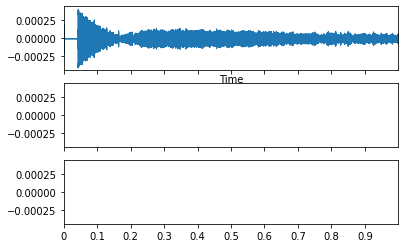

In [408]:
  data = data.reshape(1,496,64,1)
    plt.title(time.time())
    pred = model.predict(data)
    sns.barplot(x=[sum(pred[0][2:]),pred[0][0],pred[0][1]], y=['neither','glock','p320'])
    plt.show()
    display.clear_output(wait=True)

<AxesSubplot:>

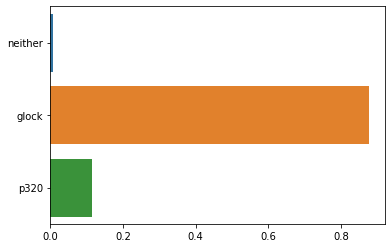